In [5]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI # Or your preferred provider



In [6]:
from langchain_core.tools import tool

@tool
def search_weather(city: str):
    """Consult this tool to get the weather."""
    # In a real app, this hits an API. Here, it's a local mock.
    return f"The weather in {city} is sunny and 25°C."

tools = [search_weather]

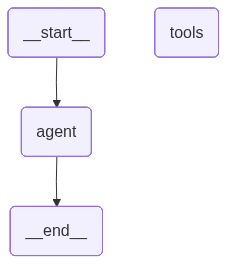

In [ ]:
# 1. Define the State (the "memory" of our graph)
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]    # 
    
# 2. Define the LLM 
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

def call_model(state: State):
    response = model.invoke(state["messages"])
    return {"messages": [response]}

# 3. Setup the Graph
workflow = StateGraph(State)

workflow.add_node("call-model", call_model)
workflow.add_node("tools", ToolNode(tools))

# The Edge Logic: Does the last message have tool_calls?
def should_continue(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        print('-> tools')
        return "tools"
    print('-> END')
    return END

workflow.add_edge(START, "call-model")
workflow.add_conditional_edges("call-model", should_continue)
workflow.add_edge("tools", "call-model") # Go back to call-model to summarize result

app = workflow.compile()
app

In [8]:
# The input must match the 'State' TypedDict we defined
initial_input = {"messages": [("user", "What is the weather in London?")]}

# Run it synchronously
final_state = app.invoke(initial_input)

# Look at the last message in the history
print(final_state["messages"][-1].content)

-> tools
-> END
The weather in London is currently sunny with a temperature of 25°C.
